# Example: Using DARTS Deep Models via TSFB

Notebook này minh họa cách làm việc với DARTS_DEEP_MODELS trong dự án tsfb, giống như khi dùng một thư viện dự báo riêng biệt.
Ở đây sử dụng mô hình học sâu BlockRNNModel của thư viện darts, được TSFB bao bọc lại.

Layout gồm có:
1. Sử dụng 1 phần nhỏ bộ dữ liệu thật M5.

2. Định nghĩa các siêu tham số (hyperparameters) cần thiết cho mô hình DARTS.

3. Khởi tạo mô hình thông qua adapter của TSFB (get_models).

4. Huấn luyện mô hình với dữ liệu và tạo dự báo.

## Step 1: Chuẩn bị dữ liệu
Bộ dữ liệu M5 Forecasting từ Kaggle là dữ liệu bán hàng theo ngày của nhiều sản phẩm trong các cửa hàng Walmart.
Trong ví dụ này chỉ lấy một sản phẩm duy nhất và cắt 300 ngày gần nhất.

Dữ liệu được chuẩn hóa thành một DataFrame gồm hai cột:
- date: ngày quan sát (dạng datetime, làm index)
- sales: số lượng bán ra mỗi ngày

Đây là định dạng đầu vào tiêu chuẩn cho các model trong TSFB, dễ tương thích với các adapter của Darts.

In [1]:
import os
import zipfile
import urllib.request

ZIP_URL = "https://github.com/Nixtla/m5-forecasts/raw/main/datasets/m5.zip"
ZIP_FILE = "m5.zip"
EXTRACTED_NAME = "sales_train_validation.csv"

# Tải file và giải nén
def download_and_extract():
    print("Đang tải zip dữ liệu M5")
    urllib.request.urlretrieve(ZIP_URL, ZIP_FILE)
    print("Tải xong, giải nén")
    with zipfile.ZipFile(ZIP_FILE, 'r') as z:
        z.extract(EXTRACTED_NAME)
    print("Giải nén xong")

# Kiểm tra
if not os.path.exists(EXTRACTED_NAME):
    try:
        download_and_extract()
    except Exception as e:
        raise RuntimeError(
            "Không thể tự động tải/giải nén dữ liệu"
            "Tải file `m5.zip` từ link sau, giải nén và sử dụng bộ dữ liệu `sales_train_validation.csv` "
            + ZIP_URL
        )

Đang tải zip dữ liệu M5
Tải xong, giải nén
Giải nén xong


In [2]:
# Đọc file csv 
import pandas as pd
raw_df = pd.read_csv("sales_train_validation.csv")
raw_df.head()

,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [3]:
# Bỏ 5 cột đầu (metadata), lấy dữ liệu bán hàng theo ngày
item_series = raw_df.iloc[0, 5:] 

# Chuyển index thành dạng ngày
start_date = pd.to_datetime("2011-01-29")  # ngày bắt đầu trong M5
dates = pd.date_range(start=start_date, periods=len(item_series), freq="D")

# Tạo Dataframe
df = pd.DataFrame({
    "date": dates,
    "sales": pd.to_numeric(item_series.values, errors="coerce")  # đảm bảo là numeric
})

# Lấy phần nhỏ, reset index, và set date làm index
data = df.tail(300).set_index("date")

print(data.head())

            sales
date             
2015-06-30      2
2015-07-01      0
2015-07-02      0
2015-07-03      0
2015-07-04      1


## Step 2: Định nghĩa hyperparameters
TSFB sử dụng cơ chế “model factory”, trong đó mỗi mô hình được định nghĩa thông qua một config bao gồm:

- model_name: tên lớp mô hình gốc trong thư viện Darts.
              Danh sách đầy đủ các deep model được TSFB hỗ trợ nằm trong biến DARTS_DEEP_MODELS của file darts_factory.py: https://github.com/vnpt-ds-core/forecasting/blob/main/tsfb/base/models/darts/darts_factory.py

- model_hyper_params: bao gồm tham số bắt buộc cho BlockRNNModel là input_chunk_length (số bước quá khứ mô hình quan sát) và output_chunk_length (số bước tương lai cần dự báo); cùng các tham số khác như hidden_dim, dropout, v.v. (đọc thêm trong documents của Darts: https://unit8co.github.io/darts/generated_api/darts.models.forecasting.block_rnn_model.html)

Các tham số bắt buộc cho mọi mô hình deep được khai báo trong DEEP_MODEL_REQUIRED_ARGS của file darts_conf.py; còn cấu hình mặc định của trainer (như accelerator, devices) nằm trong DEEP_MODEL_ARGS: https://github.com/vnpt-ds-core/forecasting/blob/main/tsfb/conf/darts_conf.py

Config này mô phỏng cách pipeline của TSFB đọc file config .yaml trong môi trường production.

In [4]:
from tsfb.conf import darts_conf

# Optional: Ghi đè mặc định toàn cục cho Apple Silicon: dùng CPU
darts_conf.DEEP_MODEL_ARGS['pl_trainer_kwargs'].update({
    'accelerator': 'cpu',  
    'devices': 1,
})

# Tạo config giả
fake_config = {
    "models": [
        {
            "model_name": "darts.models.BlockRNNModel",
            "model_hyper_params": {
                "input_chunk_length": 36,
                "output_chunk_length": 14
            }
        }
    ]
}

/opt/miniconda3/envs/vnpt_ts311_arm/lib/python3.11/site-packages/fs/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore
/opt/miniconda3/envs/vnpt_ts311_arm/lib/python3.11/site-packages/mlflow/pyfunc/model.py:187: UserWarning: Type hint used in the model's predict function is not supported for MLflow's schema validation. Type hints must be wrapped in list[...] because MLflow assumes the predict method to take multiple input instances. Specify your type hint as `list[typing.Any]` for a valid signature. Remove the type hint to disable this warning. To enable validation for the input data, specify input example or model signature when logging the model. 
  func_info = _get_func_info_if_type_hint_supported(predict_at

## Step 3: Khởi tạo mô hình
Hàm get_models() sẽ đọc fake_config, truyền model_name sang lớp gốc trong thư viện Darts, rồi tự động bọc nó bằng adapter của TSFB. Cơ chế adapter cho deep models được định nghĩa trong hàm darts_deep_model_adapter ở darts_factory.py: https://github.com/vnpt-ds-core/forecasting/blob/main/tsfb/base/models/darts/darts_factory.py

Việc chọn adapter tự động được thực hiện trong model_loader.py, nơi TSFB tra cứu tên mô hình (model_name_key) và gọi adapter tương ứng: https://github.com/vnpt-ds-core/forecasting/blob/main/tsfb/base/models/model_loader.py

Adapter này giúp chuẩn hóa input/output, xử lý split dữ liệu train/validation, và gọi đúng quy trình .fit() và .forecast() của Darts.

In [5]:
from tsfb.base.models.model_loader import get_models

# Lấy danh sách ModelFactory dựa trên cấu hình
model_factories = get_models(fake_config)

# Khởi tạo mô hình đầu tiên (vì đang chỉ khai báo một mô hình)
model = model_factories[0]()

model

2025-10-09 13:47:35,592 - INFO - Trying to load model tsfb.base.models.darts.models.BlockRNNModel
2025-10-09 13:47:35,592 - INFO - Loading model tsfb.base.models.darts.models.BlockRNNModel failed
2025-10-09 13:47:35,593 - INFO - Error: No module named 'tsfb.base.models.darts.models'
2025-10-09 13:47:35,593 - INFO - Trying to load model darts.models.BlockRNNModel
2025-10-09 13:47:35,594 - INFO - Using auto adapter for model: BlockRNNModel


BlockRNNModel

## Step 4: Huyến luyện & dự báo
Phương thức forecast_fit() của adapter sẽ chia dữ liệu thành train/validation theo train_ratio_in_tv và chuyển DataFrame thành darts.TimeSeries: https://github.com/vnpt-ds-core/forecasting/blob/main/tsfb/base/models/darts/darts_models.py

In [6]:
# Fit model
model.forecast_fit(train_data=data, train_ratio_in_tv=0.9)

# Dùng forecast() để dự báo cho các 'horizon' kế tiếp
horizon = fake_config["models"][0]["model_hyper_params"]["output_chunk_length"] # truyền từ config
predictions = model.forecast(horizon=horizon, series=data)

# Tạo DataFrame cho dữ liệu dự báo
future_index = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=horizon, freq='D')
preds_df = pd.DataFrame(predictions, index=future_index, columns=['prediction'])

preds_df.head()

/opt/miniconda3/envs/vnpt_ts311_arm/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/opt/miniconda3/envs/vnpt_ts311_arm/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/miniconda3/envs/vnpt_ts311_arm/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/opt/miniconda3/envs/vnpt_ts311_arm/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


,prediction
2016-04-25,0.601986
2016-04-26,0.728034
2016-04-27,0.715104
2016-04-28,0.729377
2016-04-29,0.853345


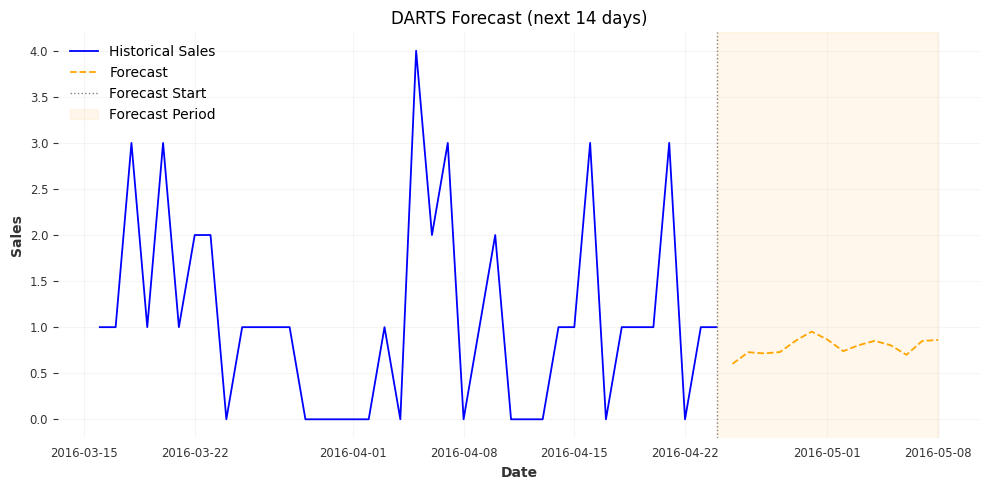

In [9]:
# Plot kết qủa
import matplotlib.pyplot as plt

# Giới hạn 40 ngày gần nhất
lookback_days = 40
plot_data = data.tail(lookback_days)

plt.figure(figsize=(10, 5))
plt.plot(plot_data.index, plot_data['sales'], label='Historical Sales', color='blue')
plt.plot(preds_df.index, preds_df['prediction'], label='Forecast', color='orange', linestyle='--')

plt.axvline(x=data.index[-1], color='gray', linestyle=':', linewidth=1, label='Forecast Start')
plt.axvspan(data.index[-1], preds_df.index[-1], color='orange', alpha=0.08, label='Forecast Period')

plt.title(f'DARTS Forecast (next {len(preds_df)} days)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Mô hình dự báo cho thấy doanh số trong 14 ngày tới có xu hướng duy trì quanh mức trung bình gần nhất, không xuất hiện biến động lớn. So với dữ liệu lịch sử dao động mạnh, phần dự báo ổn định hơn, phản ánh việc mô hình ưu tiên bắt xu hướng tổng thể thay vì các đỉnh nhọn hiếm gặp. Kết quả này gợi ý rằng mô hình đang kỳ vọng doanh số tiếp tục ở mức thấp và ổn định, phù hợp với hành vi dữ liệu quá khứ có nhiều ngày bằng 0 và ít chu kỳ rõ ràng.